<a href="https://colab.research.google.com/github/Abhijeet8901/Image-Colorization-using-GANs/blob/main/Image_colorization_using_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import sampler
import torchvision.datasets as dset
from torch.autograd import Variable

import os
import time
from google.colab.patches import cv2_imshow
import pickle
import cv2
import numpy as np
import glob
from PIL import Image
import shutil

from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchsummary import summary

from itertools import product
from math import sqrt

dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available()==False:
  dtype=torch.FloatTensor
print(device,dtype)

cuda <class 'torch.cuda.FloatTensor'>


Setting configuration

In [ ]:
class set_config:

  def __init__(self):
    self.cuda=torch.cuda.is_available()
    self.weight_decay=0 #set
    self.lr=4e-5 #set
    self.test_img_name=None #set
    self.batch_size=8 #set
    self.mode='train'
    self.resume=True
    self.save_path=glob.glob('drive/MyDrive/Projects/Image Colorization using GANs/weights/*')[0]
    self.dir='drive/MyDrive/Projects/Image Colorization using GANs/'
    self.lamb=100

config=set_config()
print(config.save_path)

Generator Model

In [ ]:
class Generator(nn.Module):

    def __init__(self):
      super(Generator,self).__init__()
      self.conv1=nn.Conv2d(1,64,3,stride=1,padding=1,bias=False)
      self.relu1=nn.LeakyReLU(0.2)

      self.conv2=nn.Conv2d(64,64,3,stride=2,padding=1,bias=False)
      self.bn2=nn.BatchNorm2d(64,momentum=0.5)
      self.relu2=nn.LeakyReLU(0.2)
      
      self.conv3=nn.Conv2d(64,128,3,stride=2,padding=1,bias=False)
      self.bn3=nn.BatchNorm2d(128,momentum=0.5)
      self.relu3=nn.LeakyReLU(0.2)

      self.conv4=nn.Conv2d(128,256,3,stride=2,padding=1,bias=False)
      self.bn4=nn.BatchNorm2d(256,momentum=0.5)
      self.relu4=nn.LeakyReLU(0.2)

      self.conv5=nn.Conv2d(256,512,3,stride=2,padding=1,bias=False)
      self.bn5=nn.BatchNorm2d(512,momentum=0.5)
      self.relu5=nn.LeakyReLU(0.2)

      self.conv6=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn6=nn.BatchNorm2d(512,momentum=0.5)
      self.relu6=nn.LeakyReLU(0.2)

      self.conv7=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn7=nn.BatchNorm2d(512,momentum=0.5)
      self.relu7=nn.LeakyReLU(0.2)

      self.conv8=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn8=nn.BatchNorm2d(512,momentum=0.5)
      self.relu8=nn.LeakyReLU(0.2)

      self.conv9=nn.ConvTranspose2d(512,512,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn9=nn.BatchNorm2d(512,momentum=0.5)
      self.relu9=nn.ReLU()
      
      self.conv10=nn.ConvTranspose2d(1024,512,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn10=nn.BatchNorm2d(512,momentum=0.5)
      self.relu10=nn.ReLU()

      self.conv11=nn.ConvTranspose2d(1024,512,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn11=nn.BatchNorm2d(512,momentum=0.5)
      self.relu11=nn.ReLU()

      self.conv12=nn.ConvTranspose2d(1024,256,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn12=nn.BatchNorm2d(256,momentum=0.5)
      self.relu12=nn.ReLU()

      self.conv13=nn.ConvTranspose2d(512,128,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn13=nn.BatchNorm2d(128,momentum=0.5)
      self.relu13=nn.ReLU()

      self.conv14=nn.ConvTranspose2d(256,64,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn14=nn.BatchNorm2d(64,momentum=0.5)
      self.relu14=nn.ReLU()

      self.conv15=nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn15=nn.BatchNorm2d(64,momentum=0.5)
      self.relu15=nn.ReLU()
      
      self.conv16=nn.Conv2d(128,3,1,stride=1,bias=False)

    def forward(self,img):
      
      x1=self.relu1(self.conv1(img))

      x2=self.relu2(self.bn2(self.conv2(x1)))

      x3=self.relu3(self.bn3(self.conv3(x2)))

      x4=self.relu4(self.bn4(self.conv4(x3)))

      x5=self.relu5(self.bn5(self.conv5(x4)))

      x6=self.relu6(self.bn6(self.conv6(x5)))

      x7=self.relu7(self.bn7(self.conv7(x6)))

      x8=self.relu8(self.bn8(self.conv8(x7)))

      x9=self.relu9(self.bn9(self.conv9(x8)))
      x9=torch.cat([x7,x9],1)

      x10=self.relu10(self.bn10(self.conv10(x9)))
      x10=torch.cat([x6,x10],1)

      x11=self.relu11(self.bn11(self.conv11(x10)))
      x11=torch.cat([x5,x11],1)

      x12=self.relu12(self.bn12(self.conv12(x11)))
      x12=torch.cat([x4,x12],1)

      x13=self.relu13(self.bn13(self.conv13(x12)))
      x13=torch.cat([x3,x13],1)

      x14=self.relu14(self.bn14(self.conv14(x13)))
      x14=torch.cat([x2,x14],1)

      x15=self.relu15(self.bn15(self.conv15(x14)))
      x15=torch.cat([x1,x15],1)

      x16=self.conv16(x15)
      x16=torch.tanh(x16)

      return x16
    
    def init_weights(self):

      for name,module in self.named_modules():
        if isinstance(module,nn.Conv2d) or isinstance(module,nn.ConvTranspose2d):
          nn.init.xavier_uniform_(module.weight.data)
          if module.bias is not None:
            module.bias.data.zero_()

Discriminator Model

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
      super(Discriminator,self).__init__()
      
      self.conv1=nn.Conv2d(3,64,3,stride=1,padding=1,bias=False)
      self.relu1=nn.LeakyReLU(0.2)

      self.conv2=nn.Conv2d(64,64,3,stride=2,padding=1,bias=False)
      self.bn2=nn.BatchNorm2d(64,momentum=0.5)
      self.relu2=nn.LeakyReLU(0.2)

      self.conv3=nn.Conv2d(64,128,3,stride=2,padding=1,bias=False)
      self.bn3=nn.BatchNorm2d(128,momentum=0.5)
      self.relu3=nn.LeakyReLU(0.2)

      self.conv4=nn.Conv2d(128,256,3,stride=2,padding=1,bias=False)
      self.bn4=nn.BatchNorm2d(256,momentum=0.5)
      self.relu4=nn.LeakyReLU(0.2)

      self.conv5=nn.Conv2d(256,512,3,stride=2,padding=1,bias=False)
      self.bn5=nn.BatchNorm2d(512,momentum=0.5)
      self.relu5=nn.LeakyReLU(0.2)

      self.conv6=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn6=nn.BatchNorm2d(512,momentum=0.5)
      self.relu6=nn.LeakyReLU(0.2)

      self.conv7=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn7=nn.BatchNorm2d(512,momentum=0.5)
      self.relu7=nn.LeakyReLU(0.2)

      self.conv8=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn8=nn.BatchNorm2d(512,momentum=0.5)
      self.relu8=nn.LeakyReLU(0.2)

      self.flat=nn.Flatten()
      self.fc1=nn.Linear(2048,100)
      self.relu9=nn.LeakyReLU(0.2)
      self.fc2=nn.Linear(100,1)
    
    def forward(self,img):

      x1=self.relu1(self.conv1(img))

      x2=self.relu2(self.bn2(self.conv2(x1)))

      x3=self.relu3(self.bn3(self.conv3(x2)))

      x4=self.relu4(self.bn4(self.conv4(x3)))

      x5=self.relu5(self.bn5(self.conv5(x4)))

      x6=self.relu6(self.bn6(self.conv6(x5)))

      x7=self.relu7(self.bn7(self.conv7(x6)))

      x8=self.relu8(self.bn8(self.conv8(x7)))

      x8=self.flat(x8)

      x9=self.relu9(self.fc1(x8))

      x10=torch.sigmoid(self.fc2(x9))

      return x10
    
    def init_weights(self):

      for name,module in self.named_modules():
        if isinstance(module,nn.Conv2d) or isinstance(module,nn.ConvTranspose2d):
          nn.init.xavier_uniform_(module.weight.data)
          if module.bias is not None:
            module.bias.data.zero_()
        if isinstance(module,nn.Linear):
          nn.init.xavier_uniform_(module.weight.data)

Load Dataset

In [ ]:
############ Takes about 1-2 minutes but worth it #############


shutil.unpack_archive(config.dir+"dataset/train.zip","data/")


#####################################################################

Make DataLoader

In [ ]:
class Places365Loader(data.Dataset):

    def __init__(self,mode='train'):
      
      self.mode=mode
      self.cfg=config
      self.data_root='data/'
      if self.mode=='train':
        self.data_path=self.data_root+'train/*.*'
        self.img_path_list=glob.glob(self.data_path)

      elif self.mode=='val':
        self.data_path=config.dir+'dataset/val/*.*'
        self.img_path_list=glob.glob(self.data_path)
      
      elif self.mode=='test':
        self.data_path=config.dir+'dataset/test/'+self.cfg.test_img_name

    def __getitem__(self,index):

      if self.mode=='test':

        image=cv2.imread(self.data_path)
        lab_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        lab_image= cv2.cvtColor(lab_image, cv2.COLOR_RGB2LAB)
        lab_image=lab_image.astype(np.float64)
        lab_image/=255.0
        lab_image=torch.from_numpy(lab_image.transpose(2,0,1))
        l_image=lab_image[0,:,:].unsqueeze(0)
        c_image=lab_image[1:,:,:]
        mean=torch.Tensor([0.5])
        l_image=l_image-mean.expand_as(l_image)
        c_image=c_image-mean.expand_as(c_image)
        l_image=2*l_image
        c_image=2*c_image
        gray_image=l_image
        lab_image=torch.cat([l_image,c_image],0)
        image=torch.from_numpy(image.transpose(2,0,1))
        return lab_image,gray_image,image

      if self.mode=='val':
        image=cv2.imread(self.img_path_list[index])
        lab_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        lab_image= cv2.cvtColor(lab_image, cv2.COLOR_RGB2LAB)
        lab_image=lab_image.astype(np.float64)
        lab_image/=255.0
        lab_image=torch.from_numpy(lab_image.transpose(2,0,1))
        l_image=lab_image[0,:,:].unsqueeze(0)
        c_image=lab_image[1:,:,:]
        mean=torch.Tensor([0.5])
        l_image=l_image-mean.expand_as(l_image)
        c_image=c_image-mean.expand_as(c_image)
        l_image=2*l_image
        c_image=2*c_image
        gray_image=l_image
        lab_image=torch.cat([l_image,c_image],0)
        image=torch.from_numpy(image.transpose(2,0,1))
        return lab_image,gray_image,image

      if self.mode=='train':
        image=cv2.imread(self.img_path_list[index])
        lab_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        lab_image= cv2.cvtColor(lab_image, cv2.COLOR_RGB2LAB)
        lab_image=lab_image.astype(np.float64)
        lab_image/=255.0
        lab_image=torch.from_numpy(lab_image.transpose(2,0,1))
        l_image=lab_image[0,:,:].unsqueeze(0)
        c_image=lab_image[1:,:,:]
        mean=torch.Tensor([0.5])
        l_image=l_image-mean.expand_as(l_image)
        c_image=c_image-mean.expand_as(c_image)
        l_image=2*l_image
        c_image=2*c_image
        gray_image=l_image
        lab_image=torch.cat([l_image,c_image],0)
        image=torch.from_numpy(image.transpose(2,0,1))
        return lab_image,gray_image,image
    
    def __len__(self):

      if self.mode=='test':
        return 1
      else:
        return len(self.img_path_list)

Make Collate Fucntions

In [ ]:
def train_collate(batch):

  lab_list,gray_list,img_list=[],[],[]
  for i,sample in enumerate(batch):
    lab_list.append(sample[0])
    gray_list.append(sample[1])
    img_list.append(sample[2])
  lab_imgs=torch.stack(lab_list)
  gray_imgs=torch.stack(gray_list)
  imgs=torch.stack(img_list)
  return lab_imgs,gray_imgs,imgs

def val_collate(batch):

  lab_list,gray_list,img_list=[],[],[]
  for i,sample in enumerate(batch):
    lab_list.append(sample[0])
    gray_list.append(sample[1])
    img_list.append(sample[2])
  lab_imgs=torch.stack(lab_list)
  gray_imgs=torch.stack(gray_list)
  imgs=torch.stack(img_list)
  return lab_imgs,gray_imgs,imgs

def test_collate(batch):

  lab_list,gray_list,img_list=[],[],[]
  for i,sample in enumerate(batch):
    lab_list.append(sample[0])
    gray_list.append(sample[1])
    img_list.append(sample[2])
  lab_imgs=torch.stack(lab_list)
  gray_imgs=torch.stack(gray_list)
  imgs=torch.stack(img_list)
  return lab_imgs,gray_imgs,imgs

DeProcessing Functions

In [ ]:
def imlabshow(img,mode='train',name=None):
  npimg=img.cpu().numpy()
  npimg=npimg/2 +0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  np_rgb_img=cv2.cvtColor(np_lab_img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  plt.imshow(np_rgb_img)
  plt.show()
  if mode=='test':
    np_rgb_img=cv2.cvtColor(np_rgb_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite(config.dir+'dataset/test/results/'+name+'_Original',np_rgb_img)

  #np_rgb_img=cv2.cvtColor(np_rgb_img,cv2.COLOR_RGB2BGR)
  #cv2_imshow(np_rgb_img)

def imfakeshow(img,mode='train',name=None):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 +0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  np_rgb_img=cv2.cvtColor(np_lab_img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  plt.imshow(np_rgb_img)
  plt.show()
  if mode=='test':
    np_rgb_img=cv2.cvtColor(np_rgb_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite(config.dir+'dataset/test/results/'+name+'_Fake',np_rgb_img)

def imgrayshow(img,mode='train',name=None):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 + 0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  cv2_imshow(np_lab_img)
  if mode=='test':
    cv2.imwrite(config.dir+'dataset/test/results/'+name+'_GrayScale',np_lab_img)

Save Weights and Loss History

In [ ]:
def save_weights(state,step_no):
  weight=glob.glob(config.dir+'weights/latest*')
  assert len(weight)<=1, "Multiple weights file, delete others."
  if weight:
    os.remove(weight[0])
  print("Saving weights as latest_colorize_weights_"+str(step_no))
  torch.save(state,config.dir+"weights/latest_colorize_weights_"+str(step_no)+".pth.tar")

def save_loss_hist(loss_d,loss_g):
  loss_g_hist=glob.glob(config.dir+'Gen_loss_*')
  loss_d_hist=glob.glob(config.dir+'Dis_loss_*')
  assert len(loss_g_hist)<=1, "Multiple files of Gen History"
  assert len(loss_d_hist)<=1, "Multiple files of Dis History"
  if loss_g_hist:
    os.remove(loss_g_hist[0])
  if loss_d_hist:
    os.remove(loss_d_hist[0])
  open_file = open(config.dir+"Gen_loss_hist.pkl", "wb")
  pickle.dump(loss_g, open_file)
  open_file.close()
  open_file = open(config.dir+"Dis_loss_hist.pkl", "wb")
  pickle.dump(loss_d, open_file)
  open_file.close()

Prepare for Training, Load Resumed State if possible

In [ ]:
Gen_Model=Generator().cuda()
Dis_Model=Discriminator().cuda()
Gen_Model.train()
Dis_Model.train()

dataset=Places365Loader(config.mode)
optimizer_G=optim.Adam(Gen_Model.parameters(),lr=config.lr,betas=(0.5, 0.999))
optimizer_D=optim.Adam(Dis_Model.parameters(),lr=config.lr,betas=(0.5, 0.999))
train_loader=DataLoader(dataset,config.batch_size,shuffle=True,collate_fn=train_collate)
loss_g=[]
loss_d=[]
if config.resume:
  checkpoint=torch.load(config.save_path)
  Gen_Model.load_state_dict(checkpoint['state_dict_G'])
  Dis_Model.load_state_dict(checkpoint['state_dict_D'])
  optimizer_G.load_state_dict(checkpoint['optimizer_G'])
  optimizer_D.load_state_dict(checkpoint['optimizer_D'])
  open_file=open(config.dir+'Gen_loss_hist.pkl','rb')
  loss_g=pickle.load(open_file)
  open_file.close()
  open_file=open(config.dir+'Dis_loss_hist.pkl','rb')
  loss_d=pickle.load(open_file)
  open_file.close()
  print(f'\nResume training with \'{config.save_path}\'.\n')
else:
  Gen_Model.init_weights()
  Dis_Model.init_weights()


Resume training with 'drive/MyDrive/Projects/Image Colorization using GANs/weights/latest_colorize_weights_61.pth.tar'.



Compute Loss , Train the Model

In [ ]:
torch.autograd.set_detect_anomaly(True)
step=1
if config.resume:
  step=checkpoint['step']+1
training=True
D_BCE=nn.BCELoss()
G_BCE=nn.BCELoss()
L1=nn.L1Loss()
real_label=0.9
fake_label=0.0
time_last=time.time()
while training:
  for i,(lab_imgs,gray_imgs,imgs) in enumerate(train_loader):

      lab_imgs=Variable(lab_imgs.cuda().type(dtype))
      gray_imgs=Variable(gray_imgs.cuda().type(dtype))
      imgs=Variable(imgs.cuda().type(dtype))
      #### Update D Network ####
      Dis_Model.zero_grad()
      output=Dis_Model(lab_imgs)
      output=torch.squeeze(output,1)
      error_D_real=D_BCE(output,((real_label) * torch.ones(output.size(0))).cuda())

      fake_img=Gen_Model(gray_imgs).detach()
      output=Dis_Model(fake_img)
      output=torch.squeeze(output,1)
      error_D_fake=D_BCE(output,(torch.zeros(output.size(0))).cuda())

      error_D = error_D_real + error_D_fake
      loss_d.append(error_D)
      error_D.backward()

      optimizer_D.step()

      #### Update G Network ####

      Gen_Model.zero_grad()
      fake_img=Gen_Model(gray_imgs)
      output=Dis_Model(fake_img)
      output=torch.squeeze(output,1)
      error_G_GAN=G_BCE(output,(torch.ones(output.size(0))).cuda())
      error_G_L1=L1(fake_img.view(fake_img.size(0),-1),lab_imgs.view(lab_imgs.size(0),-1))

      error_G = error_G_GAN + config.lamb * error_G_L1

      error_G.backward()
      optimizer_G.step()
      loss_g.append(error_G)
      ##########
      this_time=time.time()
      if i%50==0:
        print("Batch No -",i,"Completed with time",this_time-time_last,".Dis Losses = ",error_D_real.item(),",",error_D_fake.item(),". GAN Losses = ",error_G_GAN.item(),",",error_G_L1.item())
        with torch.no_grad():
          imfakeshow(fake_img[0])
      time_last=time.time()


  print("Epoch ",step," done")
  state={'step':step,
         'state_dict_G':Gen_Model.state_dict(),
         'state_dict_D':Dis_Model.state_dict(),
         'optimizer_G':optimizer_G.state_dict(),
         'optimizer_D':optimizer_D.state_dict()}
  save_weights(state,step)
  save_loss_hist(loss_d,loss_g)
  plt.plot(np.array(loss_d), 'r')
  plt.show()
  plt.plot(np.array(loss_g), 'r')
  plt.show()
  step+=1

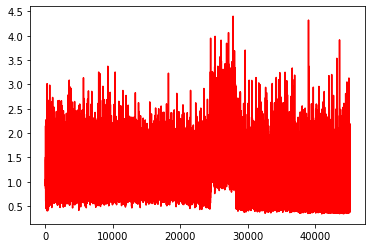

In [ ]:
plt.plot(np.array(loss_d), 'r')

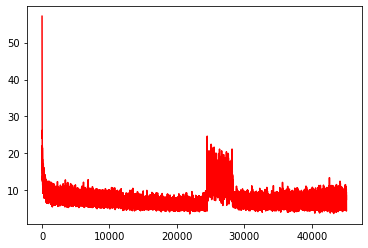

In [ ]:
plt.plot(np.array(loss_g), 'r')

###The Unusual Spike in between is due to some manual change in loss function during training.

Check on Validation Data

In [ ]:
####################### Sanity checks between training #####################
Gen_Model.eval()
BCE=nn.BCELoss()
Lloss=nn.L1Loss()
real_label=0.9
time_last=time.time()
with torch.no_grad():
  data_temp=Places365Loader('val')
  val_loader=DataLoader(data_temp,batch_size=1,shuffle=False,collate_fn=val_collate)
  for i,(lab_imgs,gray_imgs,imgs) in enumerate(val_loader):
    lab_imgs=lab_imgs.cuda().type(dtype)
    gray_imgs=gray_imgs.cuda().type(dtype)
    imgs=imgs.cuda().type(dtype)
    output=Dis_Model(lab_imgs)
    output=torch.squeeze(output,1)
    error_D_real=BCE(output,((real_label) * torch.ones(output.size(0))).cuda())

    fake_img=Gen_Model(gray_imgs)
    output=Dis_Model(fake_img)
    output=torch.squeeze(output,1)
    error_D_fake=BCE(output,(torch.zeros(output.size(0))).cuda())

    error_D = error_D_real + error_D_fake


    fake_img=Gen_Model(gray_imgs)
    output=Dis_Model(fake_img)
    output=torch.squeeze(output,1)
    error_G_GAN=BCE(output,(torch.ones(output.size(0))).cuda())
    error_G_L1=Lloss(fake_img.view(fake_img.size(0),-1),lab_imgs.view(lab_imgs.size(0),-1))

    error_G =error_G_GAN + config.lamb * error_G_L1

    this_time=time.time()
    print("Batch No -",i,"Completed with time",this_time-time_last,".Dis Losses = ",error_D_real.item(),",",error_D_fake.item(),". GAN Losses = ",error_G_GAN.item(),",",error_G_L1.item())
    time_last=time.time()
    for j in range(lab_imgs.size(0)):
      imgrayshow(gray_imgs[0])
      imlabshow(lab_imgs[0])
      imfakeshow(fake_img[0])

Test your Model

GrayScale Image - 


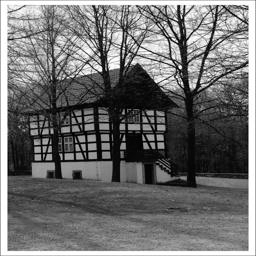

Original Image - 


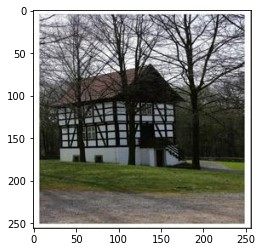

Model Output Image - 


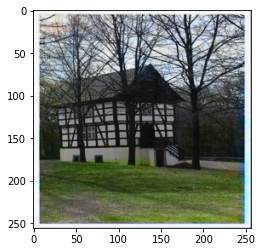

In [ ]:
################# Test Time ######################
model=Generator().to(device)
model.eval()
checkpoint=torch.load(config.save_path)
model.load_state_dict(checkpoint['state_dict_G'])
config.test_img_name="test_3.jpg"
with torch.no_grad():
  test_data=Places365Loader('test')
  test_loader=DataLoader(test_data,config.batch_size,shuffle=False,collate_fn=test_collate)
  for i,(lab_imgs,gray_imgs,imgs) in enumerate(test_loader):
    lab_imgs=lab_imgs.cuda().type(dtype)
    gray_imgs=gray_imgs.cuda().type(dtype)
    imgs=imgs.cuda().type(dtype)
    fake_img=Gen_Model(gray_imgs)
    for j in range(lab_imgs.size(0)):
      print("GrayScale Image - ")
      imgrayshow(gray_imgs[0],'test',config.test_img_name)
      print("Original Image - ")
      imlabshow(lab_imgs[0],'test',config.test_img_name)
      print("Model Output Image - ")
      imfakeshow(fake_img[0],'test',config.test_img_name)